# Simulating different noise "LFPs" and analyzing their spectral distribution

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
import neurodsp as ndsp
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
import scv_funcs
from scv_funcs import lfpca

### Double exponential synaptic noise LFP
Here, we simulate 1/f background activity as a convolution between Poisson noise and exponential rise and decay synaptic kernel (post-synaptic current).

In [3]:
# simulating
np.random.seed(42)
numtrials=100
T = 120
fs = 1000
tauR=0.002
tauD=0.02
syn_noise = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    syn_noise[tr,:] = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)

In [4]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
sn_lfpca = lfpca.LFPCA(params)
sn_lfpca.populate_ts_data(syn_noise,fs)
sn_lfpca.compute_all_spectral()
sn_lfpca.compute_KS_expfit()

As expected, the PSD follows a plateaued 1/f function (Lorentzian), and spectral coefficient of variation (SCV) at all frequencies is equal to unity. Power distribution at all frequencies are not significantly different from exponential distribution parametrized by the mean power, under KS test.

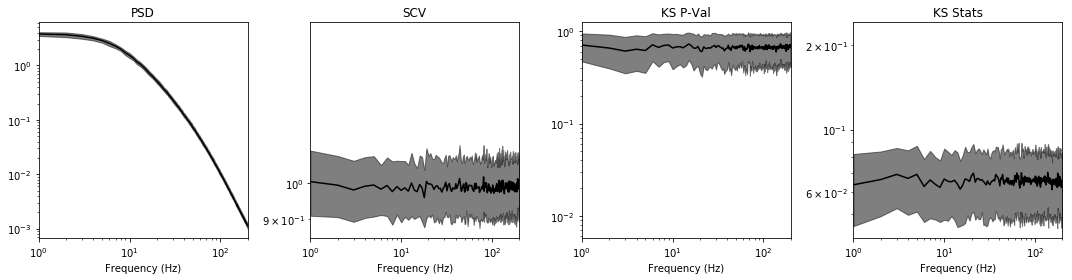

In [5]:
plt.figure(figsize=(15,4))
sn_lfpca.plot_spectral(plot_mean=True)

### Simulating stationary and bursty oscillation in noise
Now add a stationary oscillation (theta) and a bursty oscillation (beta) to the underlying 1/f background. We should expect the theta band to have low SCV, while beta band to have high SCV.

In [6]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
theta_freq=4.5
theta_amp=10
beta_freq=23.3
beta_amp=4
syn_osc = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    noise = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    # stationary theta: high entering probability and low leaving probability
    theta = ndsp.sim_bursty_oscillator(theta_freq,T,fs, rdsym=0.5, prob_enter_burst=1, prob_leave_burst=0.1)
    # bursty beta: low entering probability and low leaving probability
    beta = ndsp.sim_bursty_oscillator(beta_freq,T,fs, rdsym=0.5, prob_enter_burst=0.1, prob_leave_burst=0.1)
    syn_osc[tr,:] = noise+theta_amp*theta+beta_amp*beta

In [7]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()

As expected, we see two peaks in the PSD, one at theta and one at beta frequency. However, the theta frequencies have SCV<1 due to a steady concentration of power, while the beta frequencies have higher variability. All other frequencies remain noise-like. Both frequency bands test significantly different from the exponential null more often.

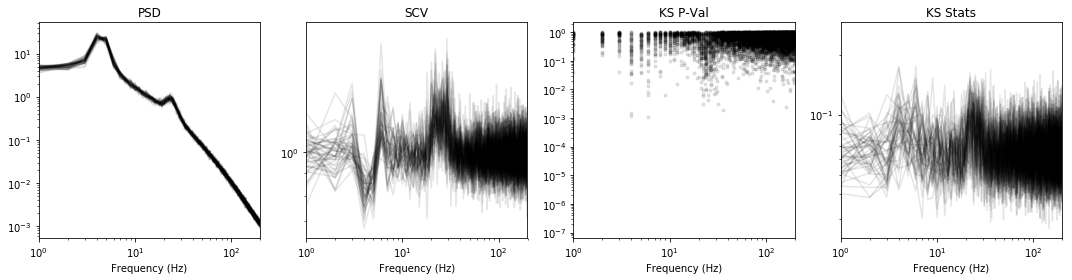

In [12]:
plt.figure(figsize=(15,4))
osc_lfpca.plot_spectral(plot_mean=False)

### Simulating oscillations and ERP-like events (or, SCP) in noise

In [9]:
def noise_analysis(x, num_trials, fs, analysis_params=None):
    if analysis_params is None:
        nperseg = int(fs)
        noverlap = 0
    else:
        nperseg = analysis_params['nperseg']
        noverlap = analysis_params['noverlap']            
    
    psd = []
    scv = []
    spg = []
    exp_scale = []
    for tr in range(num_trials):
        print(tr,end=', ')
        _, psd_ = ndsp.spectral.psd(x[:,tr], Fs=fs, nperseg=nperseg, noverlap=noverlap)
        f_axis, scv_ = ndsp.spectral.scv(x[:,tr], Fs=fs, nperseg=nperseg, noverlap=noverlap)
        _, _, spg_ = sp.signal.spectrogram(x[:,tr], fs=fs, nperseg=nperseg, noverlap=noverlap)

        # fit exponential distribution
        scale_ = np.zeros(len(f_axis))
        for f in range(len(f_axis)):
            _, scale_[f] = sp.stats.expon.fit(spg_[f,:], floc=0)
        
        # collect
        psd.append(psd_)
        scv.append(scv_)
        exp_scale.append(scale_)
    
    print('Done')
    return f_axis, np.array(psd), np.array(scv), np.array(exp_scale)

def plot_spectral(f_axis, data_plot, p_inds=np.arange(1,300)):
    titles = ['PSD', 'SCV', 'Exponential Scale Param']
    plt.figure(figsize=(12,4))
    for p in range(3):
        plt.subplot(1,3,p+1)    
        d_mean = np.mean(data_plot[p],axis=0)
        d_std = np.std(data_plot[p],axis=0)
        plt.fill_between(f_axis[p_inds],d_mean[p_inds]-d_std[p_inds],d_mean[p_inds]+d_std[p_inds], alpha=0.5)
        plt.loglog(f_axis[p_inds],d_mean[p_inds])
        if p==1:
            plt.plot([f_axis[p_inds[0]], f_axis[p_inds[-1]]], [1,1], 'k-')
        plt.xlim([f_axis[p_inds[0]], f_axis[p_inds[-1]]])
        plt.xlabel('Frequency (Hz)')
        plt.title(titles[p])
    
    p_inds = np.arange(1,300)
    data_plot = [psd, scv, exp_scale]
    plt.tight_layout()

In [3]:
dt = 0.001
fs = 1/dt
num_trials = 100
t_end = 120
t = np.arange(0,t_end,dt)
params = {
    'mu': 25,
    'sigma': 5, # variance equals mean (Poisson process)
    'theta': 10, # OU memory
    'tau': 0.05 # 
}


### white noise simulation

In [11]:
x = scv_funcs.sim_noise(t, num_trials=num_trials, color='white', params=params)
f_axis, psd, scv, exp_scale = noise_analysis(x, num_trials, fs)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Done


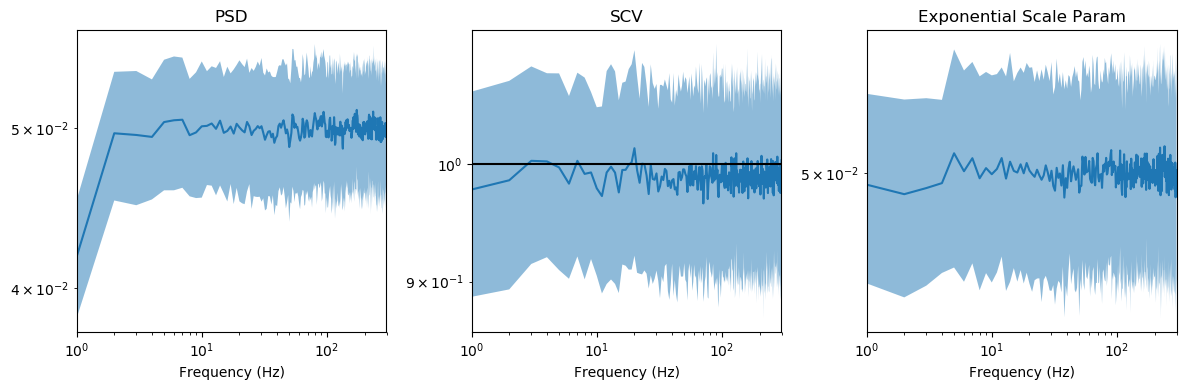

In [13]:
p_inds = np.arange(1,300)
data_plot_white = [psd, scv, exp_scale]
plot_spectral(f_axis, data_plot_white, p_inds)

### colored noise simulation

In [7]:
params = {
    'mu': 25,
    'sigma': 5, # variance equals mean (Poisson process)
    'theta': 10, # OU memory
    'tau': 0.05 # 
}
x = scv_funcs.sim_noise(t, num_trials=num_trials, color='colored', params=params)
f_axis, psd, scv, exp_scale = noise_analysis(x, num_trials, fs)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Done


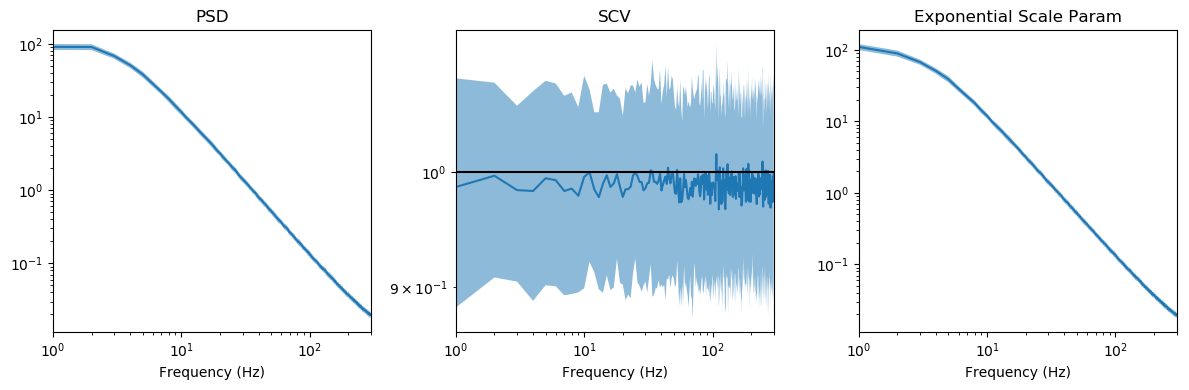

In [10]:
p_inds = np.arange(1,300)
data_plot_colored = [psd, scv, exp_scale]
plot_spectral(f_axis, data_plot_colored, p_inds)

### OU process simulation

In [14]:
params = {
    'mu': 25,
    'sigma': 5, # variance equals mean (Poisson process)
    'theta': 1, # OU memory
    'tau': 0.05 # 
}
x = scv_funcs.sim_noise(t, num_trials=num_trials, color='OU', params=params)
f_axis, psd, scv, exp_scale = noise_analysis(x, num_trials, fs)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Done


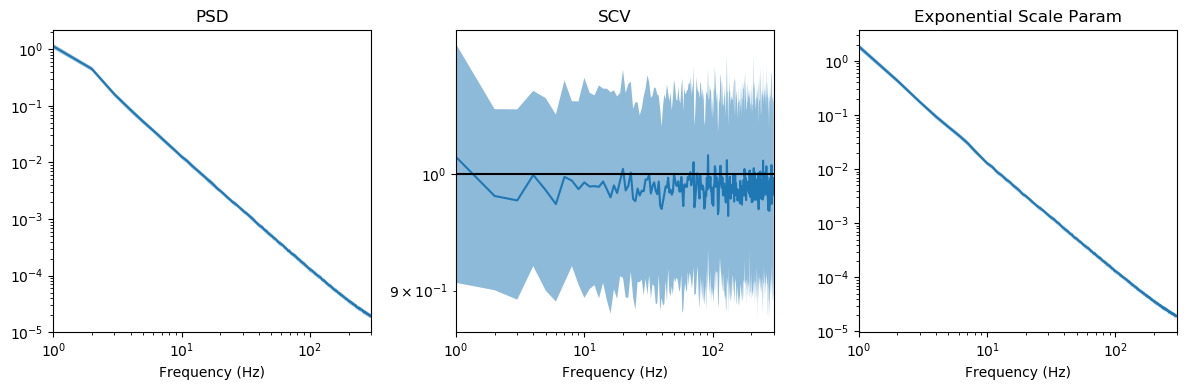

In [15]:
p_inds = np.arange(1,300)
data_plot_OU = [psd, scv, exp_scale]
plot_spectral(f_axis, data_plot_OU, p_inds)

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import sys

sys.path.append('/Users/rgao/Documents/Code/research/neurodsp/')
from neurodsp import spectral
import neurodsp as ndsp


### white and colored noise simulation
Here, we simulate white and colored noise (plus oscillation) and compute the spectral CV to see if they are indeed equal to 1.

In [ ]:
fs = 1000.
t = np.arange(0.,600.,1./fs)
ker = np.exp(-50*np.arange(0,500)/1000.)

# oscillation
oFreq = 20.22
oAmp = 20
# steady sinusoidal oscillation
osc = np.sin(2*np.pi*oFreq*np.arange(0,len(t))/fs)*1.

# initialize array
numtrs = 10
SCVnoise = np.zeros((numtrs,501,3))
for tr in range(0,numtrs):
    # run through trials
    print(tr, end=' ')
    # white noise
    x = np.random.normal(size=(len(t)))
    f, SCV = spectral.scv(x, fs, noverlap=0)
    SCVnoise[tr,:,0] = SCV
    
    # colored noise
    y = np.convolve(x,ker,mode='same')
    f, SCV = spectral.scv(y, fs, noverlap=0)
    SCVnoise[tr,:,1] = SCV    
    
    #colored noise plus oscillation
    # oscillation is bandpassed white noise, instead of just sinusoid
    #osc = ndsp.filter(np.random.normal(size=(len(t))), fs, 'bandpass', f_lo=20, f_hi=25, N_cycles=5, remove_edge_artifacts=False)*oAmp
    f, SCV = spectral.scv(y+osc, fs, noverlap=0)
    SCVnoise[tr,:,2] = SCV    


In [ ]:
mSCV = np.squeeze(np.mean(SCVnoise,axis=0))
sSCV = np.squeeze(np.std(SCVnoise,axis=0))
plt.figure(figsize=(15,5))
labels = ('white noise', 'colored noise', 'colored noise + osc')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.fill_between(f,mSCV[:,i]-sSCV[:,i], mSCV[:,i]+sSCV[:,i], alpha=0.2)
    plt.plot(mSCV[:,i])
    plt.xlim((1,200))
    plt.title(labels[i],fontsize = 28)

plt.rcParams.update({'font.size': 15})
plt.subplot(1,3,1)
plt.xlabel('Frequency (Hz)',fontsize = 22)
#plt.subplot(1,3,1)
plt.ylabel('SCV',fontsize = 22)
plt.tight_layout()

In [ ]:
faxis, taxis, spg = sp.signal.spectrogram(y, fs, nperseg=int(fs), noverlap=int(fs/4.))
plt.figure(figsize=(2,2))
plt.hist(spg[:,50], bins=np.linspace(0,0.02,100));
#plt.hist(spg[:,50]**0.5, bins=np.linspace(0,0.2,100));
plt.xlabel('Power')
#plt.xticks([0., 0.01, 0.02])
plt.ylabel('Count')
plt.title('50Hz Power Distribution')

### colored noise and oscillation demonstration
Just to visualize the scale of the oscillation compared to the noise process.

In [ ]:
oFreq = 20.22
oAmp = 1.
fs = 1000.
t = np.arange(0.,600.,1./fs)
x = np.random.normal(size=(len(t)))
ker = np.exp(-50*np.arange(0,500)/1000.)
osc = np.sin(2*np.pi*oFreq*np.arange(0,len(t))/fs)*oAmp
#osc = ndsp.filter(np.random.normal(size=(len(t))), fs, 'bandpass', f_lo=20, f_hi=23, N_cycles=10, remove_edge_artifacts=False)*20.
y = np.convolve(x,ker,mode='same')+osc
f, PSD = spectral.psd(y, fs)
f, SCV = spectral.scv(y, fs, noverlap=0)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t,y)
plt.plot(t,osc)
plt.xlim((1,2))
plt.xlabel('Time (s)',fontsize = 22)
plt.ylabel('Voltage (s)',fontsize = 22)
plt.title('Time series',fontsize = 28)


plt.subplot(1,3,2)
plt.loglog(f,PSD)
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)',fontsize = 22)
plt.ylabel('Power',fontsize = 22)
plt.title('Power Spectrum',fontsize = 28)


plt.subplot(1,3,3)
plt.plot(f,SCV)
plt.plot(f,[1.]*len(f))
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)',fontsize = 22)
plt.ylabel('SCV',fontsize = 22)
plt.title('SCV',fontsize = 28)
plt.tight_layout()

### time resolved SCV from bandpass filtered signal
Just use amp_by_time in neurodsp 

In [ ]:
sys.path.append('/Users/rgao/Documents/Code/research/CFBW_analysis/')
import CFBW

yfilt = ndsp.timefrequency.amp_by_time(y,fs,(18,22),filter_kwargs={'N_cycles': 5})**2.
plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
plt.plot(t,yfilt)
plt.xlim([0,10])
plt.title('Bandpassed Power')

plt.subplot(1,4,2)
plt.hist(yfilt, bins=50);
plt.title('Power Distribution')

scv_run = []
for win in CFBW.utils.slidingWindow(yfilt,winLen=int(fs*2.),stepLen=int(fs/2)):
    scv_run.append(np.std(win)/np.mean(win))

plt.subplot(1,4,3)
plt.plot(np.array(scv_run))
plt.title('Sliding Window SCV')

plt.subplot(1,4,4)
plt.hist(np.array(scv_run), bins=50)
plt.title('SCV Distribution')

plt.tight_layout()
print('SCV:', np.std(yfilt)/np.mean(yfilt))

### Resampled calculation of SCV for colored noise

In [ ]:
f, T, SCVrs = spectral.scv_rs(y, fs, method='bootstrap')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.loglog(f, SCVrs, 'k', alpha=0.2);
plt.loglog(f, np.mean(SCVrs,axis=1));
plt.xlim((1,100))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')

plt.subplot(1,2,2)
plt.imshow(np.log10(SCVrs), aspect='auto', extent=(0,1,f[-1],f[0]))
plt.colorbar(label='SCV')
plt.ylim((200,0))
plt.xticks([])
plt.xlabel('Slices')
plt.ylabel('Frequency (Hz)')

### Ornstein-Uhlenbeck process
OU process has a longer memory than the smoothed white noise, acheiving "true" colored noise.

Simulating a discrete-time OU process:
https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab


In [ ]:
th = 1. # memory scale (higher = faster fluc)
mu = 0. # mean
sig = 5. # std
fs = 1000.
dt = 1./fs
t = np.arange(0.,600.,1./fs)
rand = np.random.normal(size=len(t))
x0 = 0.
ex = np.exp(-th*t);
rand[0]=0.
x = x0*ex+mu*(1.-ex)+sig*ex*np.cumsum(np.exp(th*t)*np.sqrt(dt)*rand) + osc

In [ ]:
f, PSD = spectral.psd(x, fs)
f, SCV = spectral.scv(x, fs, noverlap=0)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t,x, alpha=1.)
plt.xlim((0,10.))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (s)')

plt.subplot(1,3,2)
plt.loglog(f,PSD)
plt.xlim((0,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.subplot(1,3,3)
plt.plot(f,SCV)
plt.plot(f,[1.]*len(f))
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')